In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import time  # Import the time module for measuring execution time
from datetime import datetime  # Import datetime for getting the current date and time
import numpy as np
from pathlib import Path
import torchvision.utils as vutils
import os

In [8]:
# Avoid fragmentation by limiting segment size
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"
os.environ["PYTORCH_NO_CUDA_MEMORY_CACHING"] = "1"
os.environ["TORCH_USE_CUDA_DSA"] = "1"

In [9]:
# Modular Code Structure and Configuration and Import them
from train import train
from evaluate import test
from adv_test import adv_test
from defense import feature_squeeze, gaussian_blur

In [10]:
# Hyperparameters
num_epochs = 10
batch_size = 128
learning_rate = 0.01
num_classes = 365
num_workers = 4

# epsilon for FGSM
epsilon = 8/255

root = Path("data")

In [11]:
def get_dataloader(dataset_name, batch_size):
    
    download_flag = not (root / "places365").exists()
    print(f"download={download_flag}")        # True first run, False afterwards
    
    if dataset_name == 'Places365':
        common_tf = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.Grayscale(num_output_channels=1),   # ← make it single-channel
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485], std=[0.229])
        ])

        train_dataset = datasets.Places365(
            root/"places365",
            split='train-standard',
            small=True,
            download=download_flag,
            transform=common_tf
        )
        test_dataset = datasets.Places365(
            root/"places365",
            split='val',
            small=True,
            download=download_flag,
            transform=common_tf
        )

    train_loader = torch.utils.data.DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=num_workers, 
        pin_memory=True,
        prefetch_factor=4, 
        persistent_workers=True
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=num_workers, 
        pin_memory=True,
        prefetch_factor=4, 
        persistent_workers=True
    )

    return train_loader, test_loader

In [12]:
use_cuda = True
# Define what device we are using
print("CUDA Available:", torch.cuda.is_available())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True  # autotune for fixed input sizes

CUDA Available: True


In [13]:
dataset_name = 'Places365'
model_list = 'ResNet50'

download=False
images.shape = torch.Size([128, 1, 256, 256])
labels.shape = torch.Size([128])


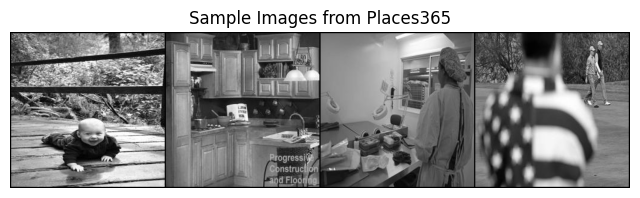

In [14]:
# Get train and test dataloader
train_loader, test_loader = get_dataloader(dataset_name, batch_size)

# Grab one batch
images, labels = next(iter(test_loader))

# Inspect shapes
print(f"images.shape = {images.shape}")
print(f"labels.shape = {labels.shape}")

# Visualize the first 4 images with their class names
grid = vutils.make_grid(images[:4], nrow=4, normalize=True)
plt.figure(figsize=(8,3))
plt.imshow(grid.permute(1,2,0))
plt.title(f"Sample Images from {dataset_name}")
plt.axis('off')
plt.show()

In [15]:
train_acc_results = {}
test_acc_results = {}
adv_acc_results = {}
feature_squeeze_test_acc_results = {}
gaussian_blur_test_acc_results = {}

In [16]:
print("==========================================")
print(f"Processing {dataset_name} dataset...")
print("==========================================")

# Create two models: Load pretrained ResNet and move to channels_last + device
model_clean = models.resnet18(pretrained=True).to(device)
model_clean.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False).to(device)
model_adv = models.resnet18(pretrained=True).to(device)
model_adv.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False).to(device)

# Use SGD with momentum and weight decay (common for robust models)
optimizer_clean = optim.SGD(model_clean.parameters(), lr=learning_rate)
optimizer_adv = optim.SGD(model_adv.parameters(), lr=learning_rate)

torch.cuda.empty_cache()

print(f"Clean Training {dataset_name} dataset...")
start_time = time.time()
train_acc = train(model_clean, device, optimizer_clean, train_loader, num_epochs, epsilon=0, adversarial=False)
train_acc_results[model_list] = train_acc
end_time = time.time()
print(f"Training time for {dataset_name}: {end_time - start_time:.2f} seconds\n")
torch.cuda.empty_cache()

start_time = time.time()
print(f"Evaluating clean test accuracy for {dataset_name}...")
test_acc = test(model_clean, device, test_loader, num_epochs)
test_acc_results[model_list] = test_acc
end_time = time.time()
print(f"Testing time for {dataset_name}: {end_time - start_time:.2f} seconds\n")
torch.cuda.empty_cache()

# Evaluate adversarial accuracy with FGSM
start_time = time.time()
print(f"Evaluating adversarial accuracy for {dataset_name} with FGSM...")
adv_acc = adv_test(model_adv, device, test_loader, epsilon, num_epochs)
adv_acc_results[model_list] = adv_acc
end_time = time.time()
print(f"Adversarial testing time for {dataset_name}: {end_time - start_time:.2f} seconds\n")
torch.cuda.empty_cache()

# Apply feature_squeeze defense on adversarial examples:
start_time = time.time()  # Start timer
print(f"Evaluating test accuracy for {dataset_name} with Feature Squeezing...")
feature_squeeze_test_acc = test(model_clean, device, test_loader, num_epochs, defense_fn=feature_squeeze, defense_params={'bit_depth': 2})
feature_squeeze_test_acc_results[model_list] = feature_squeeze_test_acc
end_time = time.time()  # End timer
testing_time = end_time - start_time
print(f"Total Testing Time with Feature Squeezing in {dataset_name}: {testing_time} seconds\n")
torch.cuda.empty_cache()

start_time = time.time()  # Start timer
print(f"Evaluating test accuracy for {dataset_name} with Gaussian Blur...")
gaussian_blur_test_acc = test(model_clean, device, test_loader, num_epochs, defense_fn=gaussian_blur, defense_params={'kernel_size': 3, 'sigma': 1.0})
gaussian_blur_test_acc_results[model_list] = gaussian_blur_test_acc
end_time = time.time()  # End timer
testing_time = end_time - start_time
print(f"Total Testing Time with Gaussian Blur in {dataset_name}: {testing_time} seconds\n")
torch.cuda.empty_cache()


Processing Places365 dataset...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Clean Training Places365 dataset...
Start Training ...


Epoch 1/10: 14090it [1:47:03,  2.19it/s]


Train Epoch 1:: Accuracy: 482065/1803460 (27%)


Epoch 2/10: 14090it [1:46:53,  2.20it/s]


Train Epoch 2:: Accuracy: 752643/1803460 (42%)


Epoch 3/10: 14090it [1:46:46,  2.20it/s]


Train Epoch 3:: Accuracy: 819830/1803460 (45%)


Epoch 4/10: 14090it [1:46:48,  2.20it/s]


Train Epoch 4:: Accuracy: 860064/1803460 (48%)


Epoch 5/10: 14090it [1:46:44,  2.20it/s]


Train Epoch 5:: Accuracy: 891708/1803460 (49%)


Epoch 6/10: 14090it [1:46:54,  2.20it/s]


Train Epoch 6:: Accuracy: 920232/1803460 (51%)


Epoch 7/10: 14090it [1:47:00,  2.19it/s]


Train Epoch 7:: Accuracy: 945597/1803460 (52%)


Epoch 8/10: 14090it [1:47:01,  2.19it/s]


Train Epoch 8:: Accuracy: 971044/1803460 (54%)


Epoch 9/10: 14090it [1:47:12,  2.19it/s]


Train Epoch 9:: Accuracy: 997092/1803460 (55%)


Epoch 10/10: 14090it [1:24:37,  2.77it/s]


Train Epoch 10:: Accuracy: 1023042/1803460 (57%)
Finished Training
Training time for Places365: 62824.29 seconds

Evaluating clean test accuracy for Places365...
Start Testing ...


Epoch 1/10: 286it [00:25, 11.28it/s]s]
 10%|█         | 1/10 [00:25<03:48, 25.36s/it]

Test Epoch 1:: Accuracy: 16744/36500 (46%)


Epoch 2/10: 286it [00:25, 11.23it/s]
 20%|██        | 2/10 [00:50<03:23, 25.42s/it]

Test Epoch 2:: Accuracy: 16744/36500 (46%)


Epoch 3/10: 286it [00:25, 11.34it/s]
 30%|███       | 3/10 [01:16<02:57, 25.34s/it]

Test Epoch 3:: Accuracy: 16744/36500 (46%)


Epoch 4/10: 286it [00:25, 11.40it/s]
 40%|████      | 4/10 [01:41<02:31, 25.24s/it]

Test Epoch 4:: Accuracy: 16744/36500 (46%)


Epoch 5/10: 286it [00:25, 11.36it/s]
 50%|█████     | 5/10 [02:06<02:06, 25.22s/it]

Test Epoch 5:: Accuracy: 16744/36500 (46%)


Epoch 6/10: 286it [00:25, 11.39it/s]
 60%|██████    | 6/10 [02:31<01:40, 25.18s/it]

Test Epoch 6:: Accuracy: 16744/36500 (46%)


Epoch 7/10: 286it [00:25, 11.29it/s]
 70%|███████   | 7/10 [02:56<01:15, 25.23s/it]

Test Epoch 7:: Accuracy: 16744/36500 (46%)


Epoch 8/10: 286it [00:25, 11.27it/s]
 80%|████████  | 8/10 [03:22<00:50, 25.28s/it]

Test Epoch 8:: Accuracy: 16744/36500 (46%)


Epoch 9/10: 286it [00:25, 11.30it/s]
 90%|█████████ | 9/10 [03:47<00:25, 25.29s/it]

Test Epoch 9:: Accuracy: 16744/36500 (46%)


Epoch 10/10: 286it [00:25, 11.29it/s]
100%|██████████| 10/10 [04:12<00:00, 25.28s/it]


Test Epoch 10:: Accuracy: 16744/36500 (46%)
Finished Testing
Testing time for Places365: 252.83 seconds

Evaluating adversarial accuracy for Places365 with FGSM...
Start Adversarial Examples Testing ...


ε=0.03137254901960784: 286it [00:26, 10.84it/s]


Epoch 1: Epsilon: 0.03137254901960784	Accuracy: 0/36500 (0%)


ε=0.03137254901960784: 286it [00:26, 10.77it/s]


Epoch 2: Epsilon: 0.03137254901960784	Accuracy: 0/36500 (0%)


ε=0.03137254901960784: 286it [00:26, 10.74it/s]


Epoch 3: Epsilon: 0.03137254901960784	Accuracy: 0/36500 (0%)


ε=0.03137254901960784: 286it [00:26, 10.71it/s]


Epoch 4: Epsilon: 0.03137254901960784	Accuracy: 0/36500 (0%)


ε=0.03137254901960784: 286it [00:26, 10.76it/s]


Epoch 5: Epsilon: 0.03137254901960784	Accuracy: 0/36500 (0%)


ε=0.03137254901960784: 286it [00:26, 10.70it/s]


Epoch 6: Epsilon: 0.03137254901960784	Accuracy: 0/36500 (0%)


ε=0.03137254901960784: 286it [00:26, 10.78it/s]


Epoch 7: Epsilon: 0.03137254901960784	Accuracy: 0/36500 (0%)


ε=0.03137254901960784: 286it [00:26, 10.74it/s]


Epoch 8: Epsilon: 0.03137254901960784	Accuracy: 0/36500 (0%)


ε=0.03137254901960784: 286it [00:26, 10.64it/s]


Epoch 9: Epsilon: 0.03137254901960784	Accuracy: 0/36500 (0%)


ε=0.03137254901960784: 286it [00:26, 10.72it/s]


Epoch 10: Epsilon: 0.03137254901960784	Accuracy: 0/36500 (0%)
Finished Adversarial Examples Testing

Adversarial testing time for Places365: 266.43 seconds

Evaluating test accuracy for Places365 with Feature Squeezing...
Start Testing ...


Epoch 1/10: 286it [00:26, 10.88it/s]s]
 10%|█         | 1/10 [00:26<03:56, 26.30s/it]

Test Epoch 1:: Accuracy: 14684/36500 (40%)


Epoch 2/10: 286it [00:26, 10.93it/s]
 20%|██        | 2/10 [00:52<03:29, 26.22s/it]

Test Epoch 2:: Accuracy: 14684/36500 (40%)


Epoch 3/10: 286it [00:26, 10.89it/s]
 30%|███       | 3/10 [01:18<03:03, 26.24s/it]

Test Epoch 3:: Accuracy: 14684/36500 (40%)


Epoch 4/10: 286it [00:26, 10.97it/s]
 40%|████      | 4/10 [01:44<02:37, 26.18s/it]

Test Epoch 4:: Accuracy: 14684/36500 (40%)


Epoch 5/10: 286it [00:26, 10.89it/s]
 50%|█████     | 5/10 [02:11<02:11, 26.21s/it]

Test Epoch 5:: Accuracy: 14684/36500 (40%)


Epoch 6/10: 286it [00:26, 10.91it/s]
 60%|██████    | 6/10 [02:37<01:44, 26.22s/it]

Test Epoch 6:: Accuracy: 14684/36500 (40%)


Epoch 7/10: 286it [00:26, 10.94it/s]
 70%|███████   | 7/10 [03:03<01:18, 26.19s/it]

Test Epoch 7:: Accuracy: 14684/36500 (40%)


Epoch 8/10: 286it [00:26, 10.92it/s]
 80%|████████  | 8/10 [03:29<00:52, 26.20s/it]

Test Epoch 8:: Accuracy: 14684/36500 (40%)


Epoch 9/10: 286it [00:26, 10.94it/s]
 90%|█████████ | 9/10 [03:55<00:26, 26.18s/it]

Test Epoch 9:: Accuracy: 14684/36500 (40%)


Epoch 10/10: 286it [00:26, 10.94it/s]
100%|██████████| 10/10 [04:21<00:00, 26.20s/it]


Test Epoch 10:: Accuracy: 14684/36500 (40%)
Finished Testing
Total Testing Time with Feature Squeezing in Places365: 261.9859473705292 seconds

Evaluating test accuracy for Places365 with Gaussian Blur...
Start Testing ...


Epoch 1/10: 286it [00:25, 11.19it/s]s]
 10%|█         | 1/10 [00:25<03:50, 25.56s/it]

Test Epoch 1:: Accuracy: 16261/36500 (45%)


Epoch 2/10: 286it [00:25, 11.17it/s]
 20%|██        | 2/10 [00:51<03:24, 25.60s/it]

Test Epoch 2:: Accuracy: 16261/36500 (45%)


Epoch 3/10: 286it [00:25, 11.20it/s]
 30%|███       | 3/10 [01:16<02:59, 25.58s/it]

Test Epoch 3:: Accuracy: 16261/36500 (45%)


Epoch 4/10: 286it [00:25, 11.22it/s]
 40%|████      | 4/10 [01:42<02:33, 25.55s/it]

Test Epoch 4:: Accuracy: 16261/36500 (45%)


Epoch 5/10: 286it [00:25, 11.27it/s]
 50%|█████     | 5/10 [02:07<02:07, 25.49s/it]

Test Epoch 5:: Accuracy: 16261/36500 (45%)


Epoch 6/10: 286it [00:25, 11.19it/s]
 60%|██████    | 6/10 [02:33<01:42, 25.51s/it]

Test Epoch 6:: Accuracy: 16261/36500 (45%)


Epoch 7/10: 286it [00:25, 11.17it/s]
 70%|███████   | 7/10 [02:58<01:16, 25.54s/it]

Test Epoch 7:: Accuracy: 16261/36500 (45%)


Epoch 8/10: 286it [00:25, 11.27it/s]
 80%|████████  | 8/10 [03:24<00:50, 25.49s/it]

Test Epoch 8:: Accuracy: 16261/36500 (45%)


Epoch 9/10: 286it [00:25, 11.21it/s]
 90%|█████████ | 9/10 [03:49<00:25, 25.50s/it]

Test Epoch 9:: Accuracy: 16261/36500 (45%)


Epoch 10/10: 286it [00:25, 11.21it/s]
100%|██████████| 10/10 [04:15<00:00, 25.52s/it]

Test Epoch 10:: Accuracy: 16261/36500 (45%)
Finished Testing
Total Testing Time with Gaussian Blur in Places365: 255.22090935707092 seconds



In [17]:
avg_train_accuracy = np.mean(train_acc_results[model_list])
avg_test_accuracy = np.mean(test_acc_results[model_list])
avg_adv_accuracy = np.mean(adv_acc_results[model_list])
avg_fs_accuracy = np.mean(feature_squeeze_test_acc_results[model_list])
avg_gb_accuracy = np.mean(gaussian_blur_test_acc_results[model_list])

print(f"Average training accuracy in {dataset_name} of {model_list}: {avg_train_accuracy}%")
print(f"Average test accuracy in {dataset_name} of {model_list}: {avg_test_accuracy}%")
print(f"Average adversarial accuracy in FGSM attack in {dataset_name} of {model_list}: {avg_adv_accuracy}%")
print(f"Average feature squeeze accuracy in {dataset_name} of {model_list}: {avg_fs_accuracy}%")
print(f"Average gaussian blur accuracy in {dataset_name} of {model_list}: {avg_gb_accuracy}%")

Average training accuracy in Places365 of ResNet50: 48.03720071418274%
Average test accuracy in Places365 of ResNet50: 45.87397260273973%
Average adversarial accuracy in FGSM attack in Places365 of ResNet50: 0.0%
Average feature squeeze accuracy in Places365 of ResNet50: 40.23013698630137%
Average gaussian blur accuracy in Places365 of ResNet50: 44.55068493150685%


In [19]:
# Combine the data into series
labels = ['Train Clean', 'Test Clean']
model_list = ['ResNet50']
data_series = [
    [train_acc_results[m] for m in model_list],
    [test_acc_results[m] for m in model_list],
]

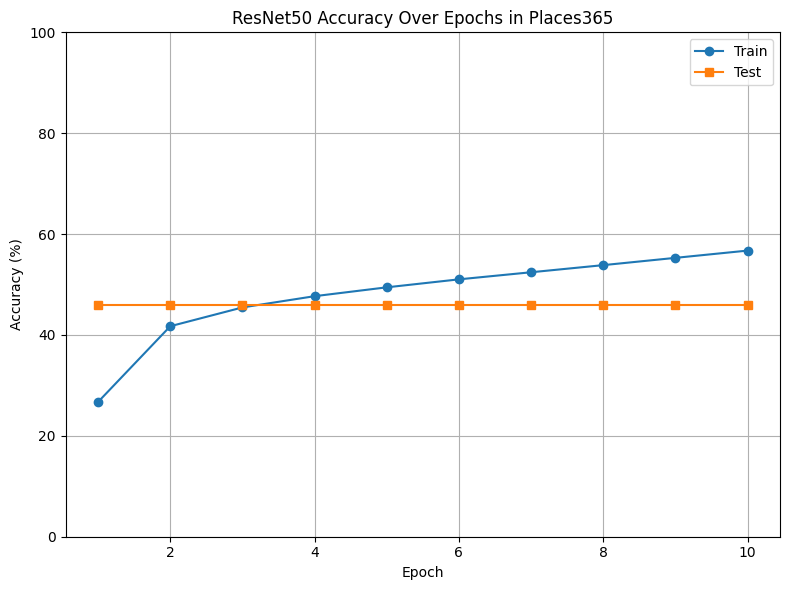

In [20]:
# Plot all types of accuracies for each dataset in subplots
fig, axs = plt.subplots(len(model_list), 1, figsize=(8, 6), sharex=True)

# num_epochs is an integer, but we need a range of epoch numbers for plotting
epoch_range = range(1, num_epochs + 1)  # Generate a list of epoch numbers [1, 2, ..., num_epochs]

# Guarantee axs is a 1D array
if not isinstance(axs, np.ndarray):
    axs = np.array([axs])

for ax, model_name in zip(axs, model_list):
    ax.plot(epoch_range, train_acc_results[model_name],   label='Train', marker='o')
    ax.plot(epoch_range, test_acc_results[model_name],    label='Test',  marker='s')

    ax.set_title(f"{model_name} Accuracy Over Epochs in {dataset_name}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy (%)")
    ax.set_ylim(0, 100)
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

In [22]:
# Combine the data into series
labels = ['FGSM Attack']
model_list = ['ResNet50']
data_series = [
    [adv_acc_results[m] for m in model_list],
]

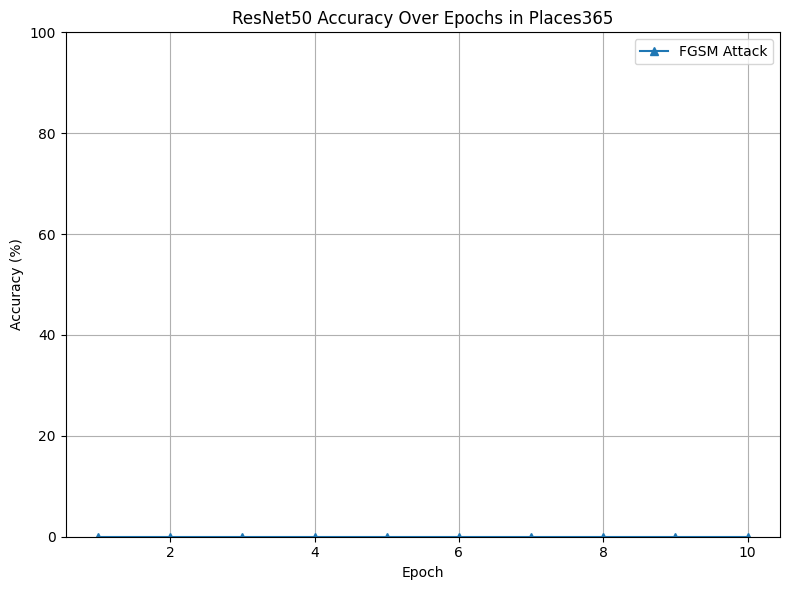

In [23]:
# Plot all types of accuracies for each dataset in subplots
fig, axs = plt.subplots(len(model_list), 1, figsize=(8, 6), sharex=True)

# num_epochs is an integer, but we need a range of epoch numbers for plotting
epoch_range = range(1, num_epochs + 1)  # Generate a list of epoch numbers [1, 2, ..., num_epochs]

# Guarantee axs is a 1D array
if not isinstance(axs, np.ndarray):
    axs = np.array([axs])

for ax, model_name in zip(axs, model_list):
    ax.plot(epoch_range, adv_acc_results[model_name],     label='FGSM Attack',  marker='^')

    ax.set_title(f"{model_name} Accuracy Over Epochs in {dataset_name}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy (%)")
    ax.set_ylim(0, 100)
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

In [25]:
# Combine the data into series
labels = ['Feature Squeeze', 'Gaussian Blur']
model_list = ['ResNet50']
data_series = [
    [feature_squeeze_test_acc_results[m] for m in model_list],
    [gaussian_blur_test_acc_results[m] for m in model_list]
]

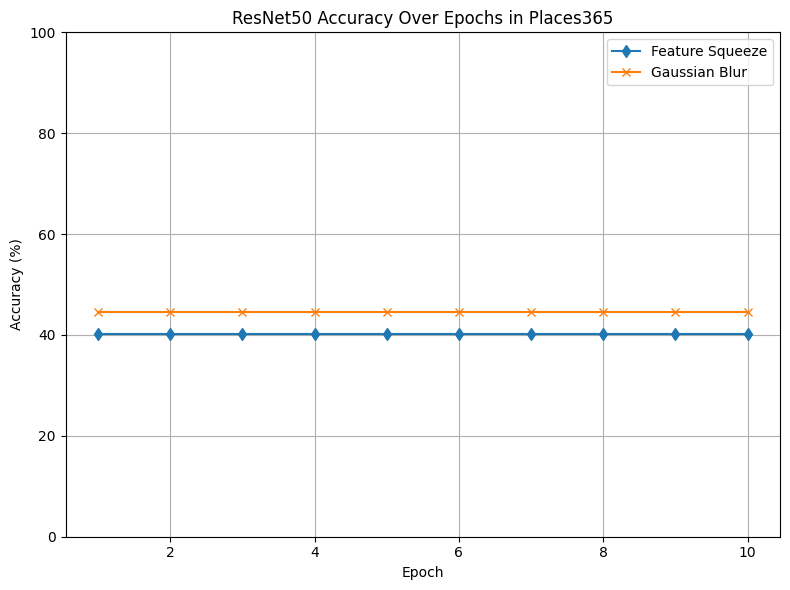

In [26]:
# Plot all types of accuracies for each dataset in subplots
fig, axs = plt.subplots(len(model_list), 1, figsize=(8, 6), sharex=True)

# num_epochs is an integer, but we need a range of epoch numbers for plotting
epoch_range = range(1, num_epochs + 1)  # Generate a list of epoch numbers [1, 2, ..., num_epochs]

# Guarantee axs is a 1D array
if not isinstance(axs, np.ndarray):
    axs = np.array([axs])

for ax, model_name in zip(axs, model_list):
    ax.plot(epoch_range, feature_squeeze_test_acc_results[model_name],
            label='Feature Squeeze', marker='d')
    ax.plot(epoch_range, gaussian_blur_test_acc_results[model_name],
            label='Gaussian Blur', marker='x')

    ax.set_title(f"{model_name} Accuracy Over Epochs in {dataset_name}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy (%)")
    ax.set_ylim(0, 100)
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()